In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [73]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [98]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps, weight_var=5.0)
std_scaling=1.
mu_scaling=0.2

In [99]:
cache_states = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Run Task (with learning)

In [100]:
model.reset()
cache_acts = []
cache_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 10
Now I just cached at location: 20
Now I just cached at location: 30
Now I just cached at location: 40
Now I just cached at location: 50
Now I just cached at location: 60
Now I just cached at location: 70
Now I just cached at location: 80


In [101]:
_, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)

In [102]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

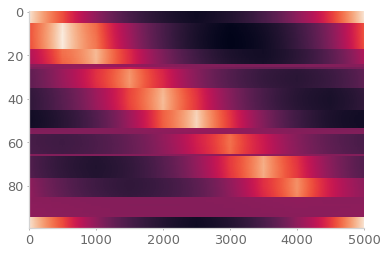

In [103]:
plt.figure()
plt.imshow(output, aspect='auto')
plt.show()

# Define cache activity as a mean over some time window

In [104]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][steps+model.seed_steps-1, location, :]#.mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [105]:
cache_mean = avg_cache_acts.mean(axis=0)

In [106]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[steps-1, location, :]#.mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

In [107]:
def nb(mu, std_scaling=std_scaling, mu_scaling=mu_scaling, shift=0.0):
#def nb(mu, std_scaling=2.0, mu_scaling=0.2, shift=0.0):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8 + shift
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    nb_mu = nbinom.rvs(n, p)
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Fig 3ab, Fig 4: cache v. visit correlation

In [108]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
cache_retrieval_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        retrieval_act_j = avg_retrieval_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)
            c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
            cache_retrieval_corr['Distance'].append(_distance)
            cache_retrieval_corr['Correlation'].append(c_r_corr)


In [109]:
# cc

In [110]:
ccc = pd.DataFrame(cache_cache_corr)
ccc = ccc[ccc['Distance']==0]
print(ccc)

     Distance  Correlation
0           0     0.236057
1           0     0.217065
2           0     0.231236
27          0     0.269108
28          0     0.204372
29          0     0.194046
51          0     0.192481
52          0     0.144780
53          0     0.257422
72          0     0.207651
73          0     0.185690
74          0     0.188987
90          0     0.253749
91          0     0.224066
92          0     0.245591
105         0     0.237532
106         0     0.214717
107         0     0.234341
117         0     0.146665
118         0     0.277615
119         0     0.250933
126         0     0.278116
127         0     0.179509
128         0     0.261575
132         0     0.173865
133         0     0.230107
134         0     0.215627


In [111]:
np.mean(ccc)

Distance       0.000000
Correlation    0.220478
dtype: float64

In [112]:
# cr

In [113]:
crc = pd.DataFrame(cache_retrieval_corr)
crc = crc[crc['Distance']==0]
print(crc)

     Distance  Correlation
0           0     0.325006
1           0     0.256354
2           0     0.252414
27          0     0.254798
28          0     0.298793
29          0     0.236101
51          0     0.272126
52          0     0.264408
53          0     0.251221
72          0     0.220879
73          0     0.248226
74          0     0.172432
90          0     0.168504
91          0     0.231265
92          0     0.298043
105         0     0.324282
106         0     0.251281
107         0     0.281673
117         0     0.196563
118         0     0.251561
119         0     0.168623
126         0     0.243523
127         0     0.285501
128         0     0.258624
132         0     0.193623
133         0     0.309963
134         0     0.220704


In [114]:
np.mean(crc)

Distance       0.0000
Correlation    0.2495
dtype: float64

In [115]:
# vv

In [116]:
vvc = pd.DataFrame(visit_visit_corr)
vvc = vvc[vvc['Distance']==0]

In [117]:
np.mean(vvc)

Distance       0.000000
Correlation    0.076828
dtype: float64

# Plot

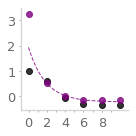

In [128]:
from scipy.optimize import curve_fit

# Exponential function to fit
def exp_func(x, a, b):
    return a * np.exp(-b * x)

fig, ax = plt.subplots(figsize=(2.,2.))
visit_visit_df = pd.DataFrame(visit_visit_corr)
cache_retrieve_df = pd.DataFrame(cache_retrieval_corr)
norm_constant = np.mean(
    visit_visit_df[visit_visit_df['Distance']==0]['Correlation']
    )
visit_visit_df['Correlation'] = visit_visit_df['Correlation'].div(norm_constant)
cache_retrieve_df['Correlation'] = cache_retrieve_df['Correlation'].div(norm_constant)
for df, color in zip(
    [visit_visit_df, cache_retrieve_df], ['black', 'purple']):
    
    # Get mean correlation at each distance and scatterplot
    mean_df = df.groupby('Distance')['Correlation'].mean().reset_index()
    ax.scatter(
        mean_df['Distance'], mean_df['Correlation'], color=color, alpha=0.8)
    
    if df is visit_visit_df: continue
    
    # Make nonzero for curve fitting
    df_nonzero = df[df['Distance'] != 0].copy()
    offset = df_nonzero['Correlation'].min()
    df_nonzero['Correlation'] = df_nonzero['Correlation'] - offset
    params, covariance = curve_fit(exp_func, df_nonzero['Distance'], df_nonzero['Correlation'])

    # Plot curve as a line
    x_values = np.linspace(0, max(df['Distance']), 100)
    ax.plot(
        x_values, exp_func(x_values, *params) + offset,
        color=color, alpha=0.8, linestyle='--')
    
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
           [0, '', 2, '', 4, '', 6, '', 8, ''])
plt.xlabel('')#'Distance (sites)')
plt.ylabel('')#'Correlation\n(norm.)')
plt.tight_layout()
plt.yticks([0, 1, 2, 3])
plt.savefig('c_r_corr.png', dpi=300)
plt.show()

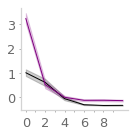

In [130]:
from scipy.optimize import curve_fit

# Exponential function to fit
def exp_func(x, a, b):
    return a * np.exp(-b * x)

fig, ax = plt.subplots(figsize=(2.,2.))
visit_visit_df = pd.DataFrame(visit_visit_corr)
cache_retrieve_df = pd.DataFrame(cache_retrieval_corr)
norm_constant = np.mean(
    visit_visit_df[visit_visit_df['Distance']==0]['Correlation']
    )
visit_visit_df['Correlation'] = visit_visit_df['Correlation'].div(norm_constant)
cache_retrieve_df['Correlation'] = cache_retrieve_df['Correlation'].div(norm_constant)
for df, color in zip(
    [visit_visit_df, cache_retrieve_df], ['black', 'purple']):

    # Plot curve as a line
    x_values = np.linspace(0, max(df['Distance']), 100)
    sns.lineplot(x='Distance', y='Correlation', data=df, color=color)
    
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
           [0, '', 2, '', 4, '', 6, '', 8, ''])
plt.xlabel('')#'Distance (sites)')
plt.ylabel('')#'Correlation\n(norm.)')
plt.tight_layout()
plt.yticks([0, 1, 2, 3])
plt.savefig('c_r_corr.png', dpi=300)
plt.show()